# Computing the betas

In order to compute the beta for both Stellantis and Walmart we took S&P 500 as benchmark.

To compute the beta for each company over the past 5 years, we will:

- Sort the data by date (in ascending order).

- Convert prices to monthly returns.

- Align returns by date across the 3 datasets.

- Perform linear regression of company returns on S&P 500 returns to compute beta.

### **Run Linear Regressions**

To estimate beta for each stock, we run an Ordinary Least Squares (OLS) regression of the stock's returns against the market returns (S&P 500). The regression equation is:

$$ r_{stock} = \alpha + \Beta \times r_{market} + \epsilon $$


Where:
- $r_{stock}$ is the return of the stock (e.g., Walmart or Stellantis)  
- $r_{market}$ is the return of the market (S&P 500)  
- $\beta$ represents the stock’s **systematic risk** (sensitivity to the market)  
- $\alpha$ is the intercept (often interpreted as abnormal return or "alpha")  
- $\epsilon$ is the error term  

The **slope coefficient (β)** from this regression is the **beta of the stock**. It tells us how much the stock’s return changes in response to changes in the market return.



In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt

# Load the datasets
walmart_df = pd.read_csv('Dataset\Investing.com\Walmart Stock Price History.csv')
stellantis_df = pd.read_csv('Dataset\Investing.com\Stellantis NV Stock Price History.csv')
sp500_df = pd.read_csv('Dataset/sp500_historical_data.csv')


<>:8: SyntaxWarning: invalid escape sequence '\I'
<>:9: SyntaxWarning: invalid escape sequence '\I'
<>:8: SyntaxWarning: invalid escape sequence '\I'
<>:9: SyntaxWarning: invalid escape sequence '\I'
C:\Users\allam\AppData\Local\Temp\ipykernel_25400\556352661.py:8: SyntaxWarning: invalid escape sequence '\I'
  walmart_df = pd.read_csv('Dataset\Investing.com\Walmart Stock Price History.csv')
C:\Users\allam\AppData\Local\Temp\ipykernel_25400\556352661.py:9: SyntaxWarning: invalid escape sequence '\I'
  stellantis_df = pd.read_csv('Dataset\Investing.com\Stellantis NV Stock Price History.csv')


In [2]:
def clean_dataframe(df):
    """
    Cleans the input DataFrame by performing the following operations:
    - Converts the 'Price' column to a float after removing commas.
    - Converts the 'Date' column to datetime format.
    - Sorts the DataFrame by the 'Date' column in ascending order.
    - Calculates the percentage change in the 'Price' column and adds it as a new column named 'Return'.
    """

    print(f"Initial DataFrame shape: {df.shape}")

    # Convert 'Price' column to float after removing commas if present
    if "Close" in df.columns:
        df.rename(columns={"Close": "Price"}, inplace=True) # Renaming for consistency, since sp500_df uses 'Close'
    if df['Price'].dtype == 'object':
        df['Price'] = df['Price'].str.replace(',', '').astype(float)

    # Convert 'Date' column to datetime format
    if df["Date"].dtype == 'object':
        # Consider only the first 10 characters of the date string
        df['Date'] = df['Date'].str[:10]
        df['Date'] = pd.to_datetime(df['Date'])

    # Sort the DataFrame by 'Date' in descending order
    df.sort_values(by='Date', ascending=True, inplace=True)

    # Compute the percentage change in 'Price' and add it as a new column 'Return'
    df['Return'] = df['Price'].pct_change().round(2) * 100
    
    return df


walmart_df = clean_dataframe(walmart_df)
stellantis_df = clean_dataframe(stellantis_df)
sp500_df = clean_dataframe(sp500_df)

Initial DataFrame shape: (60, 7)
Initial DataFrame shape: (60, 7)
Initial DataFrame shape: (60, 8)


In [3]:
# Align the returns data by date
returns_df = pd.merge(walmart_df[['Date', 'Return']], 
                      stellantis_df[['Date', 'Return']], 
                      on='Date', suffixes=('_Walmart', '_Stellantis'))
returns_df = pd.merge(returns_df, 
                      sp500_df[['Date', 'Return']], 
                      on='Date')
returns_df.rename(columns={'Return': 'Return_SP500'}, inplace=True)
returns_df.dropna(inplace=True)

X = returns_df[['Return_SP500']].values

y_walmart = returns_df['Return_Walmart'].values
beta_walmart = LinearRegression().fit(X, y_walmart).coef_[0]

y_stellantis = returns_df['Return_Stellantis'].values
beta_stellantis = LinearRegression().fit(X, y_stellantis).coef_[0]

# Print the results
print("Walmart Beta:", beta_walmart)
print("Stellantis Beta:", beta_stellantis)

# Store the results in a CSV file
pd.DataFrame(
    [["Company", "Beta"], ['Walmart', beta_walmart],
    ['Stellantis', beta_stellantis]]
).to_csv('Outputs/beta_results.csv', header=False, index=False)


Walmart Beta: 0.6932705680967155
Stellantis Beta: 1.5000000000000002


## Risk Interpretation:
### Walmart (β ≈ 0.72):

- Less volatile than the market.

- Considered a defensive stock. It tends to fluctuate less than the S&P 500.

- Suitable for risk-averse investors.

### Stellantis (β ≈ 1.42):

- More volatile than the market.

- Considered a cyclical stock. It tends to amplify market movements.

- May offer higher returns, but also higher risk.

# Risk-return on different portfolios

It is possible to analyze the risk-return profile of different portfolios by combining stocks with different betas. 

In partiulare, the average return of a portfolio composed by two stocks can be computed as:
$$ E(R_p) = w_1 \cdot E(R_1) + w_2 \cdot E(R_2) $$

Where:

- $E(R_p)$ is the expected return of the portfolio
- $w_1$ and $w_2$ are the weights of the two stocks in the portfolio (with $w_1 + w_2 = 1$)
- $E(R_1)$ and $E(R_2)$ are the expected returns of the two stocks
- $R_1$ and $R_2$ are the returns of the two stocks

The risk (standard deviation) of the portfolio can be computed as:
$$ \sigma_p = \sqrt{w_1^2 \cdot \sigma_1^2 + w_2^2 \cdot \sigma_2^2 + 2 \cdot w_1 \cdot w_2 \cdot Cov(R_1, R_2)} $$

Where:
- $\sigma_p$ is the standard deviation of the portfolio
- $\sigma_1$ and $\sigma_2$ are the standard deviations of the two stocks
- $Cov(R_1, R_2)$ is the covariance between the returns of the two stocks
- $w_1$ and $w_2$ are the weights of the two stocks in the portfolio (with $w_1 + w_2 = 1$)


In [4]:
# Calculate the average returns of the two stocks
avg_return_walmart = returns_df['Return_Walmart'].mean()
avg_return_stellantis = returns_df['Return_Stellantis'].mean()
# Calculate the standard deviation of returns of the two stocks
std_walmart = returns_df['Return_Walmart'].std()
std_stellantis = returns_df['Return_Stellantis'].std()
# Calculate the covariance matrix of the returns of the two stocks
cov_matrix = returns_df[['Return_Walmart', 'Return_Stellantis']].cov().values

# Display the results
print(f"Average Return Walmart: {avg_return_walmart:.4f}")
print(f"Average Return Stellantis: {avg_return_stellantis:.4f}")
print(f"Standard Deviation Walmart: {std_walmart:.4f}")
print(f"Standard Deviation Stellantis: {std_stellantis:.4f}")
print(f"Covariance Matrix:\n{cov_matrix}")

Average Return Walmart: 1.5593
Average Return Stellantis: 1.1525
Standard Deviation Walmart: 5.8671
Standard Deviation Stellantis: 11.5008
Covariance Matrix:
[[ 34.42314436  10.1201052 ]
 [ 10.1201052  132.26943308]]


In [5]:
# Consider a range of portfolio weights for Walmart and Stellantis (in increments of 0.01).
weights = np.linspace(0, 1, 101)
portfolio_returns = [] # List to store portfolio returns
portfolio_stds = [] # List to store portfolio standard deviations

# Iterate through the weights to calculate portfolio returns and standard deviations
for w in weights:
    w_walmart = 1- w # Weight for Walmart
    w_stellantis = w # Weight for Stellantis
    
    port_return = w_walmart * avg_return_walmart + w_stellantis * avg_return_stellantis # Portfolio return
    port_variance = (
        w_walmart**2 * std_walmart**2 +
        w_stellantis**2 * std_stellantis**2 +
        2 * w_walmart * w_stellantis * cov_matrix[0, 1] # We take from the covariance matrix the covariance between the two stocks
    )
    port_std = np.sqrt(port_variance) # Portfolio standard deviation
    
    # Append the results to the lists
    portfolio_returns.append(port_return)
    portfolio_stds.append(port_std)

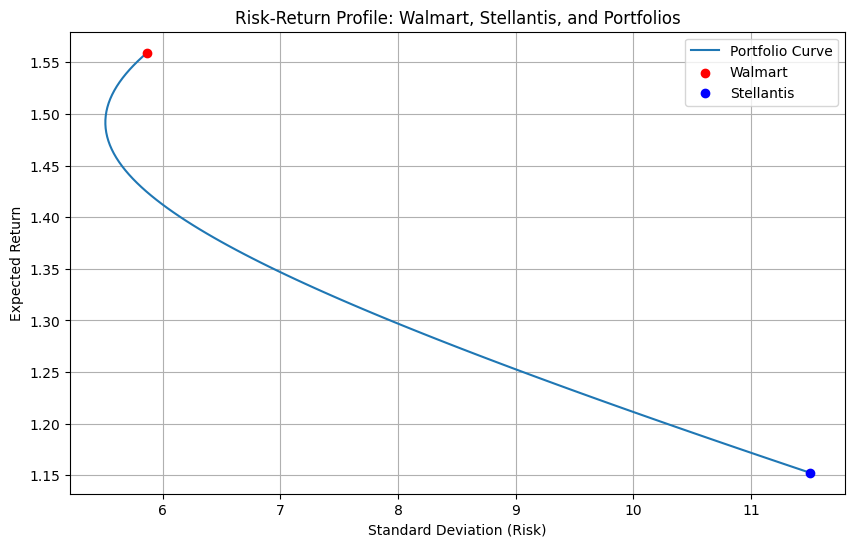

In [6]:
# Display the results with a plot 
plt.figure(figsize=(10, 6))
plt.plot(portfolio_stds, portfolio_returns, label='Portfolio Curve')
plt.scatter(std_walmart, avg_return_walmart, color='red', label='Walmart', zorder=5)
plt.scatter(std_stellantis, avg_return_stellantis, color='blue', label='Stellantis', zorder=5)
plt.title('Risk-Return Profile: Walmart, Stellantis, and Portfolios')
plt.xlabel('Standard Deviation (Risk)')
plt.ylabel('Expected Return')
plt.legend()
plt.grid(True)
plt.show()

## S: the best efficient portfolio

In [7]:
risk_free_rate = 0.0427/12  

portfolio_returns = np.array(portfolio_returns)
portfolio_stds = np.array(portfolio_stds)

sharpe_ratios = (portfolio_returns - risk_free_rate) / portfolio_stds

max_sharpe_idx = sharpe_ratios.argmax()
optimal_risky_portfolio_return = portfolio_returns[max_sharpe_idx]
optimal_risky_portfolio_std = portfolio_stds[max_sharpe_idx]

cml_x = np.linspace(0, max(portfolio_stds), 100)
cml_y = risk_free_rate + (optimal_risky_portfolio_return - risk_free_rate) / optimal_risky_portfolio_std * cml_x


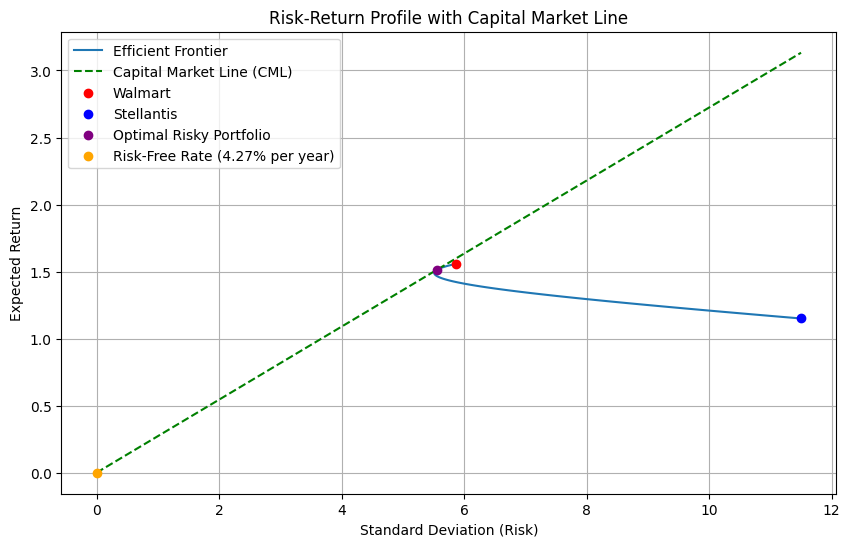

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(portfolio_stds, portfolio_returns, label='Efficient Frontier')
plt.plot(cml_x, cml_y, label='Capital Market Line (CML)', linestyle='--', color='green')
plt.scatter(std_walmart, avg_return_walmart, color='red', label='Walmart', zorder=5)
plt.scatter(std_stellantis, avg_return_stellantis, color='blue', label='Stellantis', zorder=5)
plt.scatter(optimal_risky_portfolio_std, optimal_risky_portfolio_return, color='purple', label='Optimal Risky Portfolio', zorder=5)
plt.scatter(0, risk_free_rate, color='orange', label='Risk-Free Rate (4.27% per year)', zorder=5)
plt.title('Risk-Return Profile with Capital Market Line')
plt.xlabel('Standard Deviation (Risk)')
plt.ylabel('Expected Return')
plt.legend()
plt.grid(True)
plt.show()

## But what are the specifics of S?

Below we found again S but using the statistics that refer to annual returns and not monthly.

In [9]:
annual_return_walmart = returns_df['Return_Walmart'].mean() * 12
annual_return_stellantis = returns_df['Return_Stellantis'].mean() * 12
annual_std_walmart = returns_df['Return_Walmart'].std() * np.sqrt(12)
annual_std_stellantis = returns_df['Return_Stellantis'].std() * np.sqrt(12)

cov_matrix_annual = returns_df[['Return_Walmart', 'Return_Stellantis']].cov() * 12

weights = np.linspace(0, 1, 101)
portfolio_returns = []
portfolio_stds = []
weight_combinations = []

for w in weights:
    w_walmart = w
    w_stellantis = 1 - w
    port_return = w_walmart * annual_return_walmart + w_stellantis * annual_return_stellantis
    port_variance = (
        w_walmart**2 * annual_std_walmart**2 +
        w_stellantis**2 * annual_std_stellantis**2 +
        2 * w_walmart * w_stellantis * cov_matrix_annual.iloc[0, 1]
    )
    port_std = np.sqrt(port_variance)

    portfolio_returns.append(port_return)
    portfolio_stds.append(port_std)
    weight_combinations.append((w_walmart, w_stellantis))

risk_free_rate = 0.0427

sharpe_ratios = (np.array(portfolio_returns) - risk_free_rate) / np.array(portfolio_stds)
max_sharpe_idx = sharpe_ratios.argmax()

optimal_return = portfolio_returns[max_sharpe_idx]
optimal_std = portfolio_stds[max_sharpe_idx]
optimal_weights = weight_combinations[max_sharpe_idx]

print("Optimal Expected Return:", optimal_return)
print("Optimal Standard Deviation:", optimal_std)
print("Walmart Weight:", optimal_weights[0])
print("Stellantis Weight:", optimal_weights[1])


Optimal Expected Return: 18.174915254237288
Optimal Standard Deviation: 19.240129745817345
Walmart Weight: 0.89
Stellantis Weight: 0.10999999999999999


In [10]:
w_share_price = 98.61
w_number_of_shares_outstanding = 8024000000.0
w_equity_value = w_share_price * w_number_of_shares_outstanding

w_total_liab_net_minority_int = 163131000000.00
w_Total_Debt= 60114000000.0
w_Net_Debt = 30030000000.0
w_interest_expense = -2728000000.0

s_share_price = 13.05
s_number_of_shares_outstanding = 2896073567.0
s_equity_value = s_share_price * s_number_of_shares_outstanding

s_Total_Debt= 37227000000.0
s_Net_Debt = 571000000.0
s_interest_expense = -1523000000.0

Prova calcolo Re:

In [11]:
Rf = 0.0424
Rm = 0.085
beta = beta_walmart
Rpremium = Rm - Rf

Re = Rf + beta * Rpremium
print(Re)

0.07193332620092008


In [12]:
walmart = {
    'equity_value': w_equity_value,  
    'debt_value': w_Net_Debt,    
    'cost_of_equity': 0.0771,  
    'cost_of_debt': w_interest_expense/w_Total_Debt,   
    'tax_rate': 0.2209           
}

stellantis = {
    'equity_value': s_equity_value,    
    'debt_value': s_Net_Debt,
    'cost_of_equity': 0.07,  
    'cost_of_debt': s_interest_expense/s_Total_Debt,    
    'tax_rate': 0.258           
}

def calculate_wacc(company):
    E = company['equity_value']
    D = company['debt_value']
    V = E + D
    #Re = company['cost_of_equity']
    Rd = company['cost_of_debt']
    Tc = company['tax_rate']
    
    wacc = ((E/V) * Re) + ((D/V) * Rd * (1 - Tc))
    return wacc

walmart_wacc = calculate_wacc(walmart)
stellantis_wacc = calculate_wacc(stellantis)

print(f"Walmart WACC: {walmart_wacc:.2%}")
print(f"Stellantis WACC: {stellantis_wacc:.2%}")


Walmart WACC: 6.80%
Stellantis WACC: 7.04%


## Walmart by comparables
https://www.macrotrends.net/stocks/charts/ROST/ross-stores/total-liabilities

In [13]:
walmart_fy_earnings = 19436000000
walmart_eps = walmart_fy_earnings / w_number_of_shares_outstanding

walmart_bv = (260823000000.0 - 16340200000.0) / w_number_of_shares_outstanding



walmart_pe = w_share_price / walmart_eps 
walmart_pb = w_share_price / walmart_bv 

print("walmart price to earning", walmart_pe) 
print("walmart price to book value", walmart_pb) 

walmart price to earning 40.71036427248405
walmart price to book value 3.2364102505370522


In [14]:
costco_stock_price = 923.65
target_stock_price = 135.50
kroger_co_stock_price = 61.53
ross_stock_price = 150.07


costco_eps = 16.59
target_eps = 8.86
kroger_eps = 2.96
ross_eps = 6.32

kroger_shares_outstanding = 696000000
costco_shares_outstanding = 445000000
target_shares_outstanding = 462000000
ross_shares_outstanding = 331000000



kroger_bv = (50505000000 - 38904000000) / kroger_shares_outstanding
costco_bv = (68994000000 - 43936000000) / costco_shares_outstanding
target_bv = (55356000000 - 41924000000) / target_shares_outstanding
ross_bv = (14905000000 - 9642000000) / ross_shares_outstanding


costco_pe = costco_stock_price/costco_eps
target_pe = target_stock_price/target_eps
kroger_pe = kroger_co_stock_price/kroger_eps
ross_pe = ross_stock_price/ross_eps

costco_pb = costco_stock_price/costco_bv
target_pb = target_stock_price/target_bv
kroger_pb = kroger_co_stock_price/kroger_bv
ross_pb = ross_stock_price/ross_bv

print(f"Costco price to book: {costco_pb:.2f}")
print(f"Costco price to earning: {costco_pe:.2f}")
print(f"Target price to book: {target_pb:.2f}")
print(f"Target price to earning: {target_pe:.2f}")
print(f"Kroger price to book: {kroger_pb:.2f}")
print(f"Kroger price to earning: {kroger_pe:.2f}")
print(f"Ross price to earning: {ross_pe:.2f}")
print(f"Ross price to book: {ross_pb:.2f}")

avg_pb = (costco_pb + ross_pb + kroger_pb ) / 3 # find best way not to fuckup  (probably add TJX)
avg_pe = (costco_pe + ross_pe + kroger_pe ) / 3
print(f"Average price to book: {avg_pb:.2f}")
print(f"Average price to earnings: {avg_pe:.2f}")

Costco price to book: 16.40
Costco price to earning: 55.68
Target price to book: 4.66
Target price to earning: 15.29
Kroger price to book: 3.69
Kroger price to earning: 20.79
Ross price to earning: 23.75
Ross price to book: 9.44
Average price to book: 9.84
Average price to earnings: 33.40


### DCF for Walmart